Total Files :
2032
cloth : value_of_match
jean : 0.96711147
jersey : 0.5469416
miniskirt : 0.24692991
overskirt : 0.3762985
miniskirt : 0.6158537
jean : 0.7430407
miniskirt : 0.6272288
jean : 0.9329987
jean : 0.68711525
jean : 0.5329679
jean : 0.4433193
pajama : 0.73619086
gown : 0.3016128
dumbbell : 0.3760513
jean : 0.57241476
jean : 0.5739536
jersey : 0.68950087
jean : 0.1567978
chain mail : 0.6666618
jean : 0.4600432
miniskirt : 0.29960614
jean : 0.9256873
jean : 0.8059421
miniskirt : 0.6963664
miniskirt : 0.48610544
sweatshirt : 0.24108455
sweatshirt : 0.49495947
jean : 0.41593835
jersey : 0.87644917
jersey : 0.21362668
hoopskirt : 0.35443822
jean : 0.94385195
jersey : 0.8287545
jersey : 0.4550513
maillot : 0.24117093
miniskirt : 0.5310744
miniskirt : 0.35418016
jean : 0.23414081
jean : 0.9868624
jean : 0.9083645
miniskirt : 0.60349524
jersey : 0.2351352
jean : 0.25338715
bulletproof vest : 0.1709984
balance beam : 0.15147084
jean : 0.5502704
jersey : 0.93388695
chain mail : 0.5081

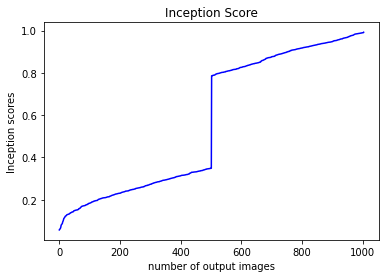

In [13]:
########################################################################
#
# The Inception Model v3 for TensorFlow.
#
# This is a pre-trained Deep Neural Network for classifying images.
# You provide an image or filename for a jpeg-file which will be
# loaded and input to the Inception model, which will then output
# an array of numbers indicating how likely it is that the
# input-image is of each class.
#
# See the example code at the bottom of this file or in the
# accompanying Python Notebooks.
#
#
# What is Transfer Learning?
#
# Transfer Learning is the use of a Neural Network for classifying
# images from another data-set than it was trained on. For example,
# the Inception model was trained on the ImageNet data-set using
# a very powerful and expensive computer. But the Inception model
# can be re-used on data-sets it was not trained on without having
# to re-train the entire model, even though the number of classes
# are different for the two data-sets. This allows us to use the
# Inception model on our own data-sets without the need for a
# very powerful and expensive computer to train it.
#
# The last layer of the Inception model before the softmax-classifier
# is called the Transfer Layer because the output of that layer will
# be used as the input in our new softmax-classifier (or as the
# input for another neural network), which will then be trained on
# our own data-set.
#
# The output values of the Transfer Layer are called Transfer Values.
# These are the actual values that will be input to our new
# softmax-classifier or to another neural network that we create.
#
#
# Implemented in Python 3.5 with TensorFlow v1.13.1
#
#
########################################################################
# The PyTorch framework supports over 200 different mathematical operations. 
# The popularity of PyTorch continues to rise as it simplifies the creation of artificial neural network (ANN) models. 
# PyTorch is mainly used for applications of research, data science and artificial intelligence (AI).
import torch
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import os
import sys
import cv2
import matplotlib.pyplot as plt
from PIL import Image

########################################################################
# Various directories and file-names.

# Internet URL for the tar-file with the Inception model.
# Note: this might change in the future and will need to be updated.
data_url = "http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz"

# Directory to store the downloaded data.
data_dir = "/content/drive/MyDrive/inception-score-pytorch/tryon/"

# File containing the mappings between class-number and uid{unique idendification no} (Downloaded)
path_uid_to_cls = "imagenet_2012_challenge_label_map_proto.pbtxt"

# File containing the mappings between uid and string. (Downloaded)
path_uid_to_name = "imagenet_synset_to_human_label_map.txt"

# so mapping is in this way class_number -> uid -> string{ name }

# File containing the TensorFlow graph definition. (Downloaded)
# A computational graph (or graph in short) is a series of TensorFlow operations arranged into a graph of nodes". 
# Basically, it means a graph is just an arrangement of nodes that represent the operations in our model.
path_graph_def = "classify_image_graph_def.pb"

########################################################################

# this class is made to look values in the downloaded already trained model
class NameLookup:
    """
    Used for looking up the name associated with a class-number.
    This is used to print the name of a class instead of its number,
    e.g. "plant" or "horse".

    Maps between:
    - cls is the class-number as an integer between 1 and 1000 (inclusive).
    - uid is a class-id as a string from the ImageNet data-set, e.g. "n00017222".
    - name is the class-name as a string, e.g. "plant, flora, plant life"

    """

    def __init__(self):
        # Mappings between uid, cls and name are dicts, where insertions and
        # lookup have O(1) time-usage on average, but may be O(n) in worst case.
        self._uid_to_cls = {}   # Map from uid to cls.
        self._uid_to_name = {}  # Map from uid to name.
        self._cls_to_uid = {}   # Map from cls to uid.

        # Read the uid-to-name mappings from file.
        path = os.path.join(data_dir, path_uid_to_name)
        with open(file=path, mode='r') as file:
            # Read all lines from the file.
            lines = file.readlines()

            for line in lines:
                # Remove newlines.
                line = line.replace("\n", "")

                # Split the line on tabs.
                elements = line.split("\t")

                # Get the uid.
                uid = elements[0]

                # Get the class-name.
                name = elements[1]

                # Insert into the lookup-dict.
                self._uid_to_name[uid] = name

        # Read the uid-to-cls mappings from file.
        path = os.path.join(data_dir, path_uid_to_cls)
        with open(file=path, mode='r') as file:
            # Read all lines from the file.
            lines = file.readlines()

            for line in lines:
                # We assume the file is in the proper format,
                # so the following lines come in pairs. Other lines are ignored.

                if line.startswith("  target_class: "):
                    # This line must be the class-number as an integer.

                    # Split the line.
                    elements = line.split(": ")

                    # Get the class-number as an integer.
                    cls = int(elements[1])

                elif line.startswith("  target_class_string: "):
                    # This line must be the uid as a string.

                    # Split the line.
                    elements = line.split(": ")

                    # Get the uid as a string e.g. "n01494475"
                    uid = elements[1]

                    # Remove the enclosing "" from the string.
                    uid = uid[1:-2]

                    # Insert into the lookup-dicts for both ways between uid and cls.
                    self._uid_to_cls[uid] = cls
                    self._cls_to_uid[cls] = uid

    def uid_to_cls(self, uid):
        """
        Return the class-number as an integer for the given uid-string.
        """

        return self._uid_to_cls[uid]

    def uid_to_name(self, uid, only_first_name=False):
        """
        Return the class-name for the given uid string.

        Some class-names are lists of names, if you only want the first name,
        then set only_first_name=True.
        """

        # Lookup the name from the uid.
        name = self._uid_to_name[uid]

        # Only use the first name in the list?
        if only_first_name:
            name = name.split(",")[0]

        return name

    def cls_to_name(self, cls, only_first_name=False):
        """
        Return the class-name from the integer class-number.

        Some class-names are lists of names, if you only want the first name,
        then set only_first_name=True.
        """

        # Lookup the uid from the cls.
        uid = self._cls_to_uid[cls]

        # Lookup the name from the uid.
        name = self.uid_to_name(uid=uid, only_first_name=only_first_name)

        return name


########################################################################


class Inception:
    """
    The Inception model is a Deep Neural Network which has already been
    trained for classifying images into 1000 different categories.

    When you create a new instance of this class, the Inception model
    will be loaded and can be used immediately without training.

    The Inception model can also be used for Transfer Learning.
    """

    # Name of the tensor for feeding the input image as jpeg.
    tensor_name_input_jpeg = "DecodeJpeg/contents:0"

    # Name of the tensor for feeding the decoded input image.
    # Use this for feeding images in other formats than jpeg.
    tensor_name_input_image = "DecodeJpeg:0"

    # Name of the tensor for the resized input image.
    # This is used to retrieve the image after it has been resized.
    tensor_name_resized_image = "ResizeBilinear:0"

    # Name of the tensor for the output of the softmax-classifier.
    # This is used for classifying images with the Inception model.
    tensor_name_softmax = "softmax:0"

    # Name of the tensor for the unscaled outputs of the softmax-classifier (aka. logits).
    tensor_name_softmax_logits = "softmax/logits:0"

    # Name of the tensor for the output of the Inception model.
    # This is used for Transfer Learning.
    tensor_name_transfer_layer = "pool_3:0"

    def __init__(self):
        # Mappings between class-numbers and class-names.
        # Used to print the class-name as a string e.g. "horse" or "plant".
        self.name_lookup = NameLookup()

        # Now load the Inception model from file. The way TensorFlow
        # does this is confusing and requires several steps.

        # TensorFlow uses graphs as the format for saved models when it exports them from Python. 
        # Graphs are also easily optimized, allowing the compiler to do transformations like: 
        # Statically infer the value of tensors by folding constant nodes in your computation ("constant folding").

        # Create a new TensorFlow computational graph.
        self.graph = tf.Graph()

        # Set the new graph as the default.
        with self.graph.as_default():

            # TensorFlow graphs are saved to disk as so-called Protocol Buffers
            # aka. proto-bufs which is a file-format that works on multiple
            # platforms. In this case it is saved as a binary file.

            # Open the graph-def file for binary reading.
            path = os.path.join(data_dir, path_graph_def)
            with tf.io.gfile.GFile(path,'rb') as file:
                # The graph-def is a saved copy of a TensorFlow graph.
                # First we need to create an empty graph-def.
                graph_def = tf.compat.v1.GraphDef()

                # Then we load the proto-buf file into the graph-def.
                graph_def.ParseFromString(file.read())

                # Finally we import the graph-def to the default TensorFlow graph.
                tf.import_graph_def(graph_def, name='')

                # Now self.graph holds the Inception model from the proto-buf file.

        # Get the output of the Inception model by looking up the tensor
        # with the appropriate name for the output of the softmax-classifier.
        self.y_pred = self.graph.get_tensor_by_name(self.tensor_name_softmax)

        # Get the unscaled outputs for the Inception model (aka. softmax-logits).
        self.y_logits = self.graph.get_tensor_by_name(self.tensor_name_softmax_logits)

        # Get the tensor for the resized image that is input to the neural network.
        self.resized_image = self.graph.get_tensor_by_name(self.tensor_name_resized_image)

        # Get the tensor for the last layer of the graph, aka. the transfer-layer.
        self.transfer_layer = self.graph.get_tensor_by_name(self.tensor_name_transfer_layer)

        # Get the number of elements in the transfer-layer.
        self.transfer_len = self.transfer_layer.get_shape()[3]

        # Create a TensorFlow session for executing the graph.
        self.session = tf.Session(graph=self.graph)

    def close(self):
        """
        Call this function when you are done using the Inception model.
        It closes the TensorFlow session to release its resources.
        """

        self.session.close()


    def _create_feed_dict(self, image_path=None, image=None):
        """
        Create and return a feed-dict with an image.

        :param image_path:
            The input image is a jpeg-file with this file-path.

        :param image:
            The input image is a 3-dim array which is already decoded.
            The pixels MUST be values between 0 and 255 (float or int).

        :return:
            Dict for feeding to the Inception graph in TensorFlow.
        """

        if image is not None:
            # Image is passed in as a 3-dim array that is already decoded.
            feed_dict = {self.tensor_name_input_image: image}

        elif image_path is not None:
            # Read the jpeg-image as an array of bytes.
            image_data = tf.gfile.FastGFile(image_path, 'rb').read()

            # Image is passed in as a jpeg-encoded image.
            feed_dict = {self.tensor_name_input_jpeg: image_data}

        else:
            raise ValueError("Either image or image_path must be set.")

        return feed_dict

    def classify(self, image_path=None, image=None):
        """
        Use the Inception model to classify a single image.

        The image will be resized automatically to 299 x 299 pixels,

        :parameter image_path:
            The input image is a jpeg-file with this file-path.

        :parameter image:
            The input image is a 3-dim array which is already decoded.
            The pixels MUST be values between 0 and 255 (float or int).

        :return:
            Array of floats (aka. softmax-array) indicating how likely
            the Inception model thinks the image is of each given class.
        """

        # Create a feed-dict for the TensorFlow graph with the input image.
        feed_dict = self._create_feed_dict(image_path=image_path, image=image)

        # Execute the TensorFlow session to get the predicted labels.
        pred = self.session.run(self.y_pred, feed_dict=feed_dict)

        # Reduce the array to a single dimension.
        pred = np.squeeze(pred)

        return pred


    def print_scores(self, pred, k=10, only_first_name=True):
        """
        Print the scores (or probabilities) for the top-k predicted classes.

        :param pred:
            Predicted class-labels returned from the predict() function.

        :param k:
            How many classes to print.

        :param only_first_name:
            Some class-names are lists of names, if you only want the first name,
            then set only_first_name=True.

        :return:
            Nothing.
        """

        # Get a sorted index for the pred-array.
        idx = pred.argsort()

        # The index is sorted lowest-to-highest values. Take the last k.
        top_k = idx[-k:]

        # Iterate the top-k classes in reversed order (i.e. highest first).
        for cls in reversed(top_k):
            # Lookup the class-name.
            name = self.name_lookup.cls_to_name(cls=cls, only_first_name=only_first_name)
            print(name,end=" : ")
            # Predicted score (or probability) for this class.
            score = pred[cls]

            return score

########################################################################

from pathlib import Path
from os import path

if __name__ == '__main__':
    # print(tf.__version__)

    # Download Inception model if not already done.
    # array
    
    files = []
    path = Path('/content/drive/MyDrive/inception-score-pytorch/tryon')

    # made an array which stores the names of all jpeg data
    
    for file in path.iterdir():
      file = str(file)
      # we are checking because we have put the pretrained model in the same tryon directory
      if(file[-3:]=='jpg'):
       files.append(file[-12:])

    no_files=len(files)
    print("Total Files :")
    print(no_files)

    # Load the Inception model so it is ready for classifying images.
    model = Inception()
    all_scores=[]
    print("cloth : value_of_match")
    for x in files:
      # Path for a jpeg-image that is included in the downloaded data.
      image_path = os.path.join(data_dir,x)
      # eg of image_path = /content/drive/MyDrive/inception-score-pytorch/tryon/000001_0.jpg

      # Use the Inception model to classify the image.
      pred = model.classify(image_path=image_path)

      score=model.print_scores(pred=pred, k=1)
      all_scores.append(score)
      print(score)
    
    all_scores.sort()
    new_score=[]

    for i in range(0,502):
      new_score.append(all_scores[i])

    for i in range(1530,no_files):
      new_score.append(all_scores[i])

    sum=0.0
    for x in new_score:
      sum=sum+x
    # used to find the mean
    mean=sum/(len(new_score))

    # done to find standard variance
    total_sum=0.0
    for x in new_score:
      val=((x-mean)*(x-mean))
      total_sum=total_sum+val

    S_D=total_sum/(len(new_score))
    S_D=S_D**0.5
    print("standard deviation is :")
    print(S_D)
    print("Mean is :")
    print(mean)

    # y-axis shows the inception scores 
    # x-axis shows the no of images
    x = np.array(new_score)
    plt.title("Inception Score")
    plt.plot(x, color="blue")
    plt.xlabel('number of output images')
    plt.ylabel('Inception scores')

    plt.show()

    # Close the TensorFlow session.
    model.close()

########################################################################